In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import os, sys, glob
import cartopy.crs as ccrs

from contrails.satellites.goes.abi import *

from tqdm.auto import tqdm

t0 = dt.datetime(2023, 8, 4, 0)

def get_local_path(time):
    return f"../data/height_estimates/{time.strftime('%Y%m%d/%Y%m%d_%H_%M.pkl')}"


dfs = []
for t in tqdm(pd.date_range(t0, t0+dt.timedelta(days=1), freq="5min")):
    
    try:
        df = pd.read_pickle(get_local_path(t))
        df["time"] = t
        dfs.append(df)
    except FileNotFoundError:
        pass

/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


  0%|          | 0/289 [00:00<?, ?it/s]

In [3]:
dfs = []
root = "/net/d15/data/vmeijer/contrail-height-estimation/case_study/20230821/glad-resonance-1575_epoch_40/"

t0 = dt.datetime(2023, 8, 21, 8)
for t in tqdm(pd.date_range(t0, t0+dt.timedelta(hours=24), freq="10min")):
    
    try:
        path = root + os.path.basename(get_local_path(t)).replace(".pkl", "_new.parquet")

        df = pd.read_parquet(path)
        df["time"] = t
        dfs.append(df)
    except FileNotFoundError:
        print(f"Did not find file for {t}")
        pass

  0%|          | 0/145 [00:00<?, ?it/s]

In [27]:
from contrails.satellites.goes.utils import get_lons, get_lats

In [28]:
df["longitude"] = get_lons()[df.row.values, df.col.values]
df["latitude"] = get_lats()[df.row.values, df.col.values]

In [30]:
height_cols = [col for col in df.columns if "height_" in col]
df[height_cols] = df[height_cols] * 1.1279025836154375 + 11.74518137474533

In [31]:
time = dt.datetime(2023, 8, 21, 12)

In [32]:
from quantnn.quantiles import posterior_mean

df["mean"] = posterior_mean(df[[c for c in df.columns if 'height' in c]].values, np.array([float(c.split("_")[1]) for c in df.columns if "height" in c]))

In [38]:
df["height"] = df["mean"]

In [39]:
import seaborn as sns

In [40]:
def generate_geographical_figure(data, ax=None, fig=None, no_lons=False, no_lats=False,
                                no_colorbar=False, bax_height=0.1,
                                lax_width=0.1, no_lax_label=False,
                                no_bax_label=False):
    
    if ax is None:
        fig, ax = plt.subplots(dpi=300, figsize=(7.2, 7.2), subplot_kw={"projection": ccrs.PlateCarree()})
 
    extent = [-135, -45, 10, 55]
    ax.set_extent(extent)


    ALPHA = 0.01

    vmin = 8
    vmax = 15
    cmap = "viridis"

    sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax))

    # time = dt.datetime(2023, 8, 21, 15)
    # data = df[df.time == time]

    cf = ax.scatter(data.longitude.values, data.latitude.values, transform=ccrs.PlateCarree(),
              s=1, c=data.height.values, alpha=ALPHA, cmap=cmap, zorder=5,
                   vmin=vmin, vmax=vmax)


    gl = ax.gridlines(zorder=0, ylocs =[20, 30-0.175, 40-0.35, 50-0.5])
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAKES, fc="none", ec="k")


    pos = ax.get_position()
    
    if not no_colorbar:
        cax = fig.add_axes([pos.x0, pos.y1+0.025, pos.x1 - pos.x0, 0.025])
        plt.colorbar(sm, cax=cax, label="Contrail top height, km", orientation="horizontal")

        cax.xaxis.tick_top()
        cax.xaxis.set_label_position("top")

    lax = fig.add_axes([pos.x0-lax_width, pos.y0, lax_width, pos.y1-pos.y0])
    bax = fig.add_axes([pos.x0, pos.y0-bax_height, pos.x1-pos.x0, bax_height])


    #sns.histplot(y="caliop_lat", data=data, ax=lax, binwidth=5)
    lax.scatter(data.height.values, data.latitude.values, s=1, alpha=ALPHA, c=data.height.values,
               vmin=vmin, vmax=vmax, cmap=cmap, zorder=2)
    lax.set_xlim(vmin, vmax)
    # lax.set_xscale("log")
    lax.invert_xaxis()
    lax.xaxis.tick_top()
    lax.xaxis.set_label_position('top')
    lax.set(ylabel="Latitude", xlabel= "" if no_lax_label else "Altitude,\n km")
    
    if no_lax_label:
        lax.set_xticks([])
    lax.set(ylabel="Latitude")
    lax.set_ylim(*extent[2:3])
    
    lax.grid(axis='y')
    lax.yaxis.set_major_formatter(LatitudeFormatter())
    if no_lats:
        lax.set_yticklabels([])
        lax.set(ylabel="")
    # sns.rugplot(data=df, y="latitude", ax=lax, mean=0.1, alpha=0.25, c="k")


    bax.scatter(data.longitude.values, data.height.values, s=1, alpha=ALPHA,
                c=data.height.values,
               vmin=vmin, vmax=vmax, cmap=cmap)

    bax.set(xlabel="Longitude")
    if not no_bax_label:
        bax.set_ylabel("Altitude,\n km", rotation='horizontal', ha='left',
                       va='bottom')
    else:
        bax.set_yticklabels([])
        
    # bax.invert_yaxis()
    bax.set_xlim(*extent[:2])
    bax.set_xticks([-135, -120, -100, -80, -60, -45])
    bax.grid(axis="x")
    bax.set_ylim(vmin, vmax)
    #bax.invert_yaxis()
    # bax.set_yscale("log")
    bax.yaxis.tick_right()
    bax.yaxis.set_label_position("right")
    bax.xaxis.set_major_formatter(LongitudeFormatter())
    
    if no_lons:
        bax.set_xticklabels([])
        bax.set(xlabel="")
    # bax.set_yticks([500])
    # sns.rugplot(data=df, x="longitude", ax=bax, mean=0.1, alpha=0.1, c="k")


    ax.plot(np.linspace(ORTHO_EXTENT[0], ORTHO_EXTENT[1], 100), [ORTHO_EXTENT[2]]*100, 
            c="r", zorder=2,
            transform=ORTHO_PROJ)

    ax.plot(np.linspace(ORTHO_EXTENT[0], ORTHO_EXTENT[1], 100), [ORTHO_EXTENT[3]]*100, 
            c="r", zorder=2,
            transform=ORTHO_PROJ)
    ax.plot([ORTHO_EXTENT[0]] * 100, np.linspace(ORTHO_EXTENT[2], ORTHO_EXTENT[3], 100),
            c="r", zorder=2,
            transform=ORTHO_PROJ)

    ax.plot([ORTHO_EXTENT[1]] * 100, np.linspace(ORTHO_EXTENT[2], ORTHO_EXTENT[3], 100),
            c="r", zorder=2,
            transform=ORTHO_PROJ, label="Detection domain")

    ax.add_feature(cfeature.LAKES, fc="none", ec="k", zorder=0)

    selected_extent = [-98.5795 + (-35.45),
                       39.8283 + (-29.42),
                       -98.5795 + 35.45,
                       39.8283 + 10.25]

    #plt.close()
    



In [41]:
import cartopy.feature as cfeature
from matplotlib.cm import ScalarMappable

from matplotlib.colors import Normalize

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [42]:
plt.rc("font", family="serif")

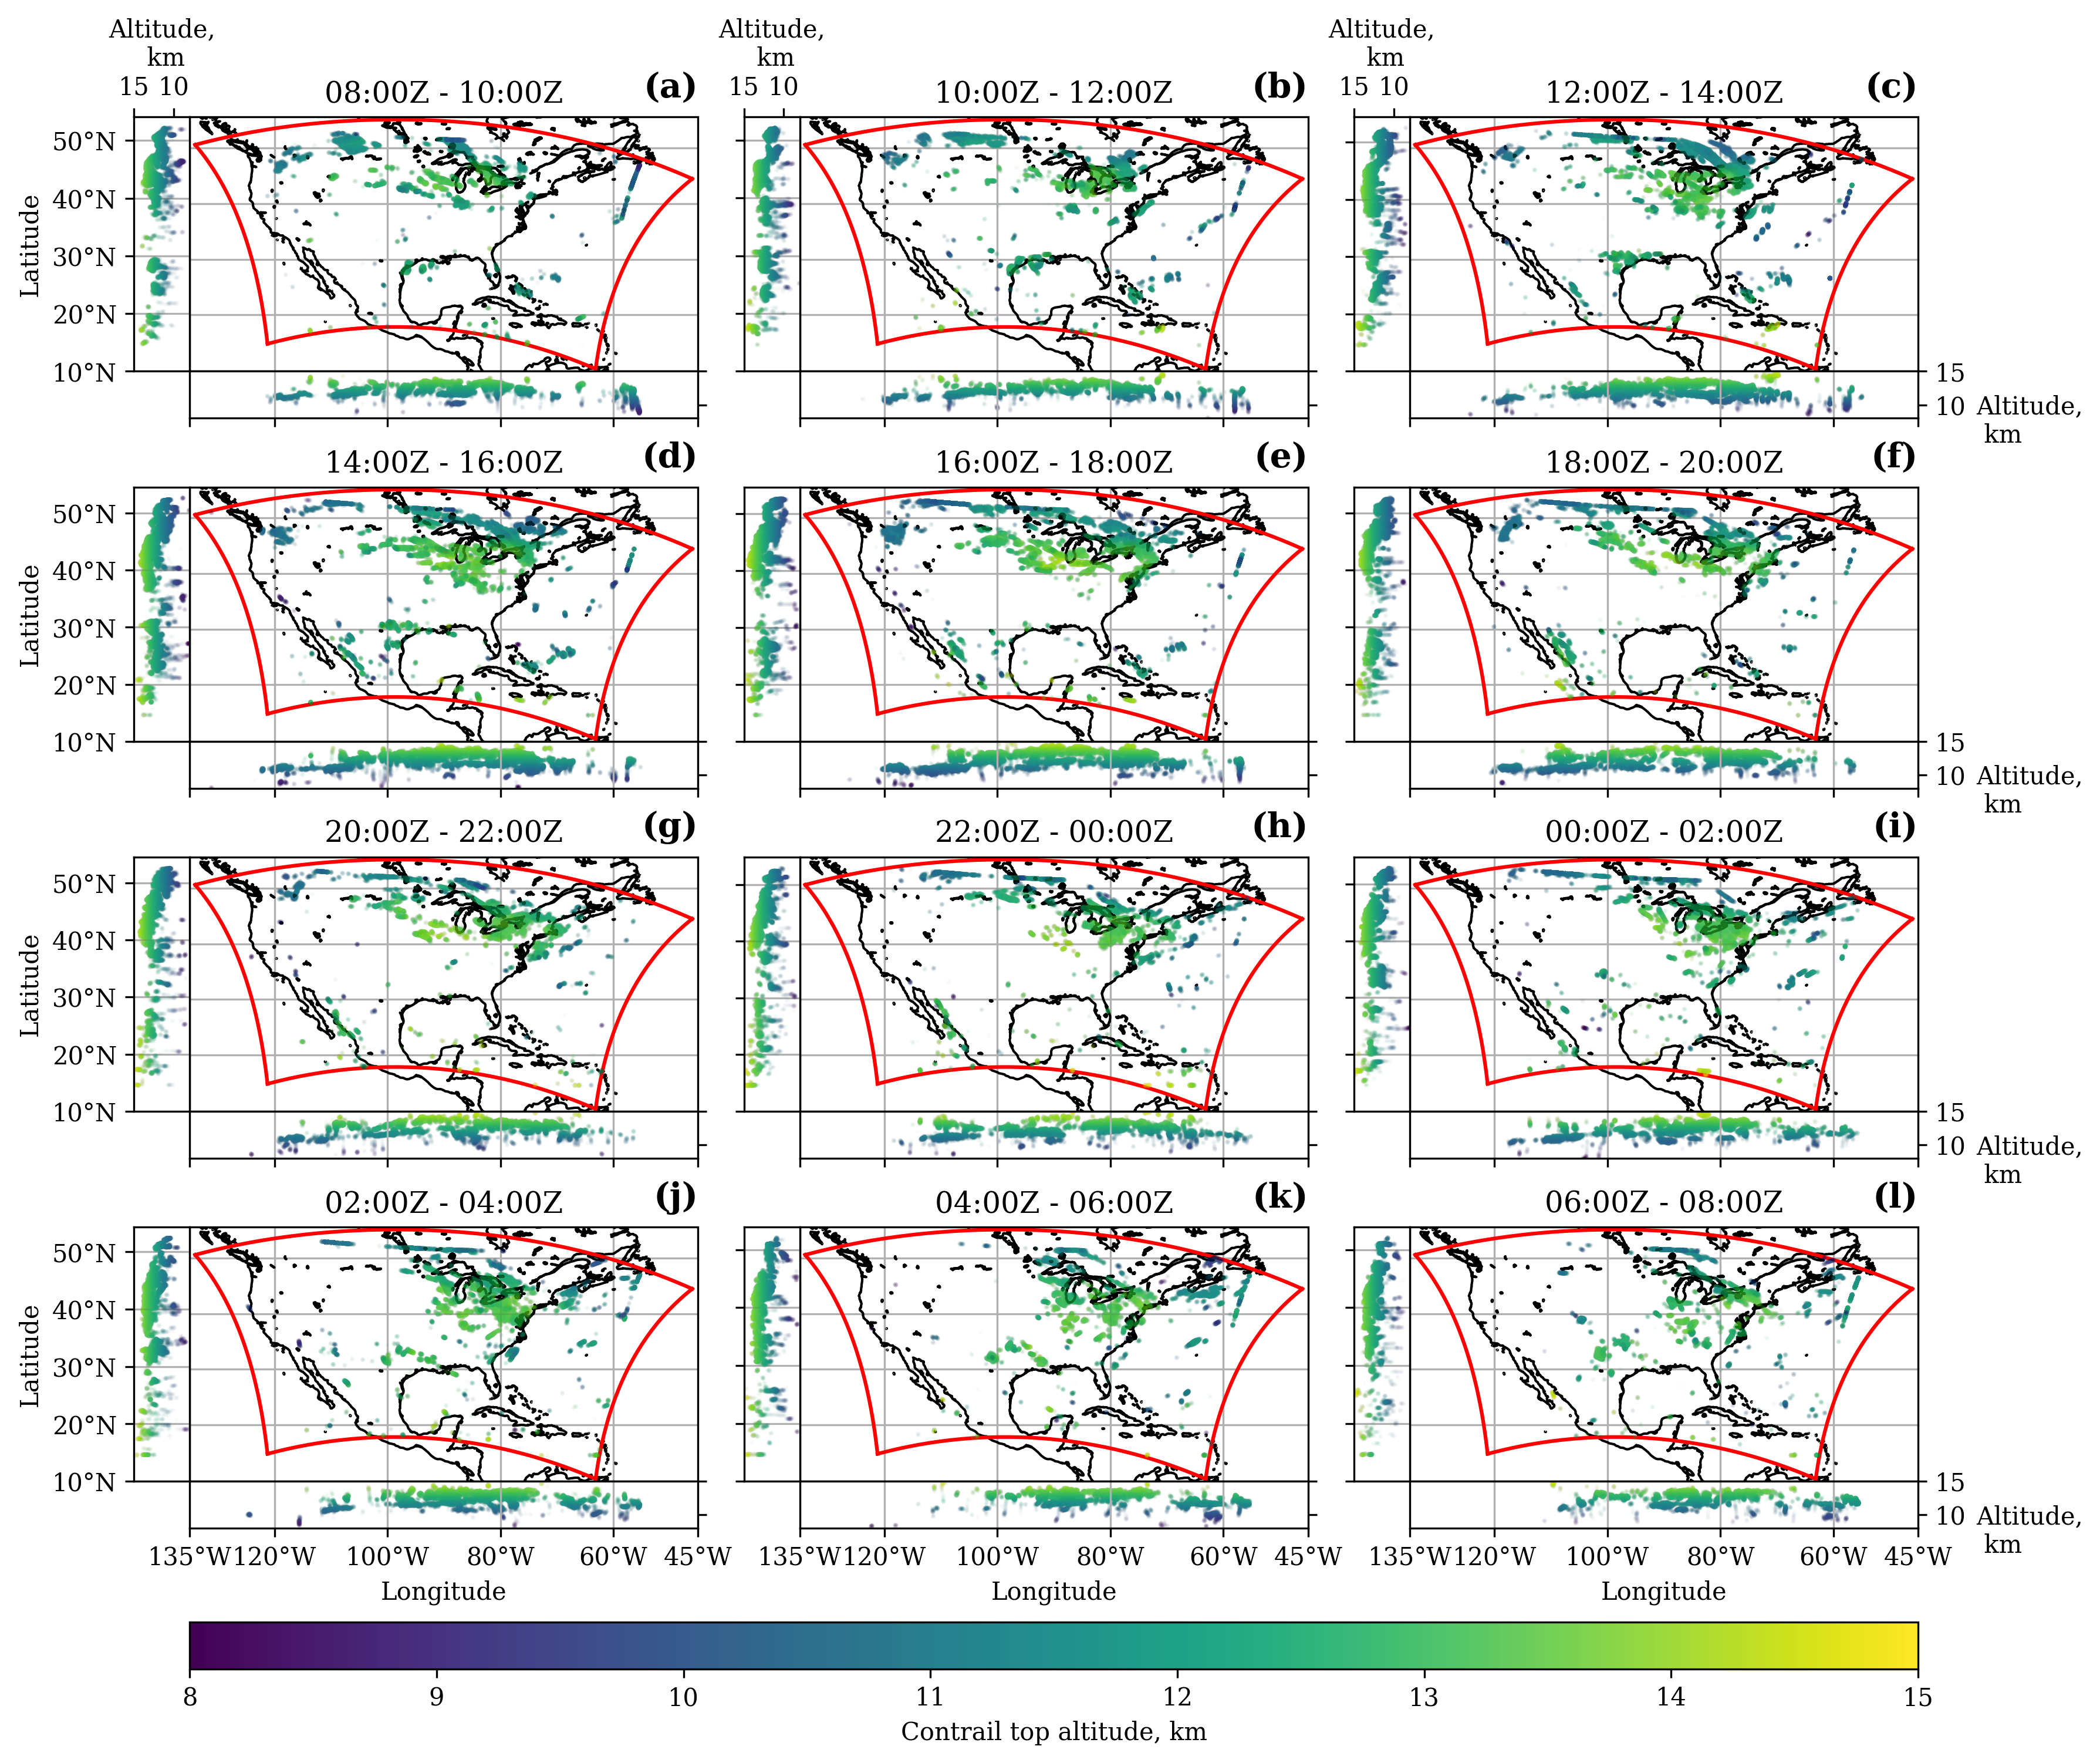

In [43]:
f = 2/3
fig, axes = plt.subplots(dpi=300, figsize=(f * 19, f * 16),
                         ncols=3, nrows=4,
                         subplot_kw=dict(projection=ccrs.PlateCarree()))

vmin = 8
vmax = 15
cmap = "viridis"

sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax))
t0 = dt.datetime(2023, 8, 21, 8)
for i in range(12):
    
    r, c = np.unravel_index(i, axes.shape)
    
    time = t0 + dt.timedelta(hours=2*i)
    generate_geographical_figure(df[(df.time >= time)*(df.time < time + dt.timedelta(hours=2))],
                                ax=axes[r,c], fig=fig, no_lats=c!=0,
                                no_lons=r!=3, no_colorbar=True, no_lax_label=r!=0,
                                 no_bax_label=c!=2,
                                bax_height=0.025, lax_width=0.025)
    axes[r,c].set(title=f"{time.strftime('%H:%MZ')} - {(time + dt.timedelta(hours=2)).strftime('%H:%MZ')}")
    

    axes[r,c].text(1.0, 1.05, "(" + chr(97 + i) + ")", transform=axes[r,c].transAxes, 
            size=14, weight="bold", va="bottom", ha="right")
    
# for r in range(4):
   
#     pos = axes[r,-1].get_position()

#     cax = fig.add_axes([pos.x1 + 0.025, pos.y0, 0.01, pos.y1 - pos.y0])
#     plt.colorbar(sm, cax=cax, label="Contrail top height, km")


pos0 = axes[-1,0].get_position()
pos1 = axes[-1,-1].get_position()
cax = fig.add_axes([pos0.x0, pos0.y0 - 0.1, pos1.x1 - pos0.x0, 0.025])
                  


plt.colorbar(sm, cax=cax, label="Contrail top altitude, km", orientation='horizontal')
cax.xaxis.tick_bottom()
cax.xaxis.set_label_position("bottom")
plt.show()

# Figure 8 

In [60]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.dates import DateFormatter

In [ ]:
unique_times = df.time.unique()

In [62]:
df["height"] = df["mean"]

df["height_bin"] = np.clip(np.floor(df.height.values - 8.0), 0, 6)

grouped = df.groupby(["height_bin", "time"]).count()
unique_times = df.time.unique()

from matplotlib.colors import BoundaryNorm, ListedColormap
colors = plt.cm.viridis(np.arange(6.0)/5.0)
norm = BoundaryNorm(np.arange(8, 16), 7)

total = df.groupby("time").count().row.values

oi = df.groupby(["time", "height_bin"]).count()[["row"]].reset_index().pivot(index="time", columns="height_bin", values="row")

rel = oi.copy()
for k in rel.columns:
    rel[k] = 100 *rel[k].values / total
    
rel[rel.isna()] = 0.0
total = oi.sum(axis=1)

<ipython-input-63-7b9967aad820>:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('viridis')(x/6.0)
<ipython-input-63-7b9967aad820>:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('viridis')(x/6.0)


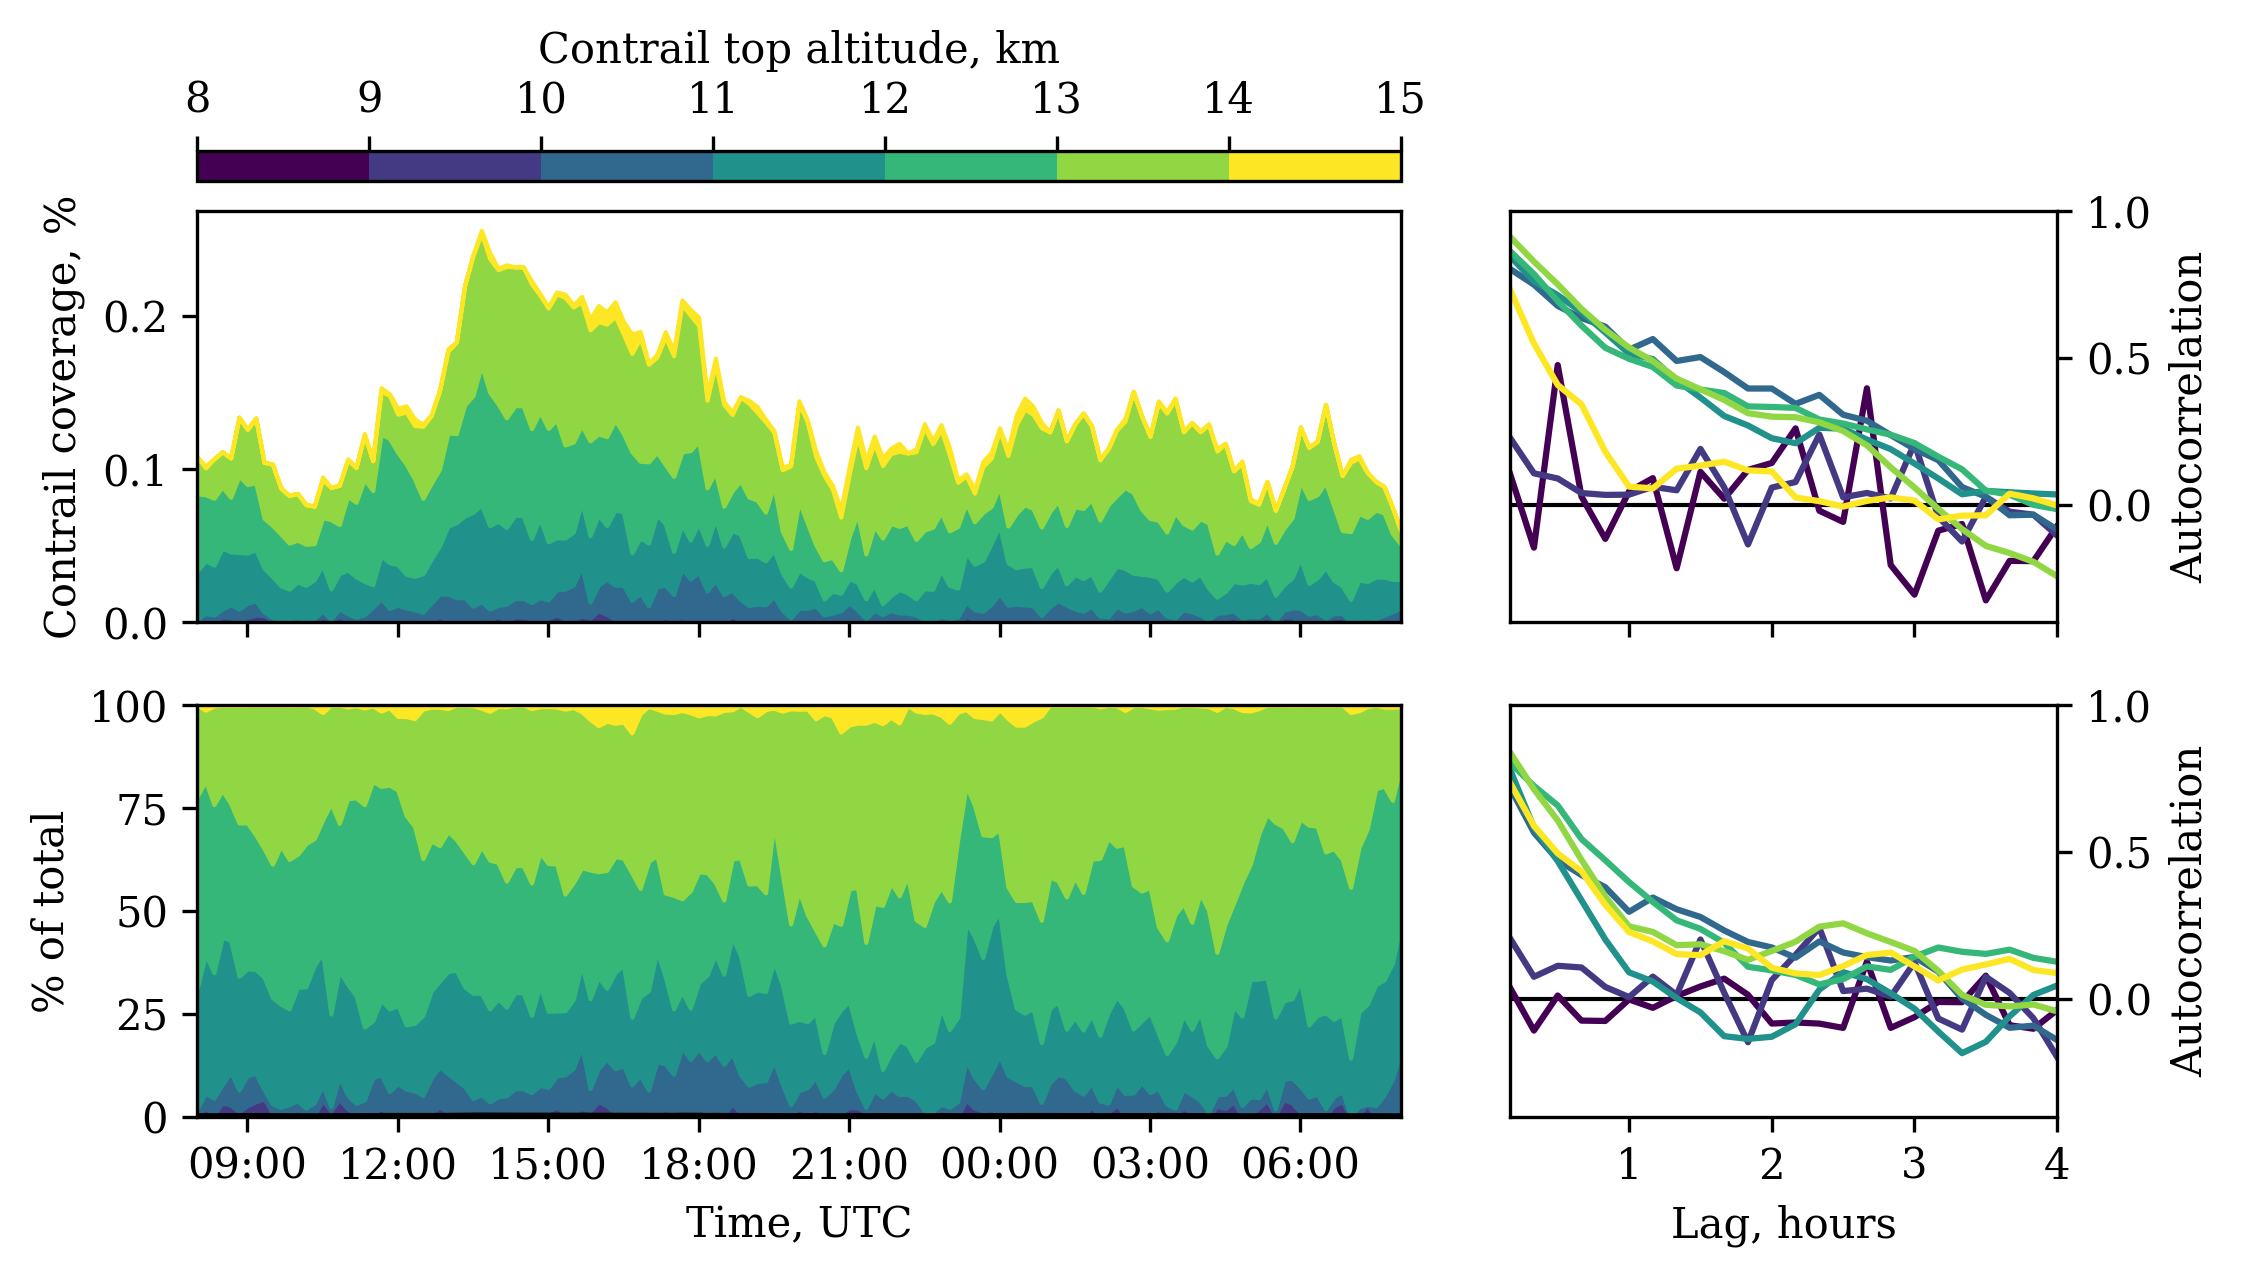

In [63]:
fig = plt.figure(dpi=300, figsize=(8, 4))



grid = GridSpec(2, 3)

ax = fig.add_subplot(grid[0, :2])

prev_t_series = np.zeros(len(unique_times))

cmap = ListedColormap([plt.cm.viridis(i) for i in np.linspace(0, 1, 7)])
norm = BoundaryNorm(list(np.arange(8, 16)), 7)

for i, h in enumerate(np.arange(7.0)):
    
    tseries = prev_t_series.copy()

    mask = np.isin(unique_times, grouped.loc[h].index)
    tseries[mask] += grouped.loc[h].row.values
    
    ax.fill_between(unique_times, 100 * prev_t_series / 6e6, 100 * tseries / 6e6, color=cmap(norm(h+8.0)))
    
    prev_t_series = tseries
    
#ax.plot(unique_times, 100 * prev_t_series / 6e6, c="k")
#plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Contrail top height, km")
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax.set_xlim(unique_times[0], unique_times[-1])
ax.set_ylim(0,)
ax.set(ylabel="Contrail coverage, %")
ax.set_xticklabels([])
ax0 = ax

ax = fig.add_subplot(grid[1, :2])

prev_t_series = np.zeros(len(unique_times))

cmap = ListedColormap([plt.cm.viridis(i) for i in np.linspace(0, 1, 7)])
norm = BoundaryNorm(list(np.arange(8, 16)), 7)

for i, h in enumerate(np.arange(7.0)):
    
    tseries = prev_t_series.copy()

    mask = np.isin(unique_times, grouped.loc[h].index)
    tseries[mask] += grouped.loc[h].row.values
    
    ax.fill_between(unique_times, 100 * prev_t_series / total, 100 * tseries / total, color=cmap(norm(h+8.0)))
    
    prev_t_series = tseries
    
ax.plot(unique_times, 100 * prev_t_series / 6e6, c="k")
#plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Contrail top height, km")
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax.set_xlim(unique_times[0], unique_times[-1])
ax.set_ylim(0,100)
ax.set(ylabel="% of total", xlabel="Time, UTC")

pos0 = ax0.get_position()
cax = fig.add_axes([pos0.x0, pos0.y1 + 0.025, pos0.x1 - pos0.x0, 0.025])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax,
             label="Contrail top altitude, km", orientation="horizontal")

cax.xaxis.tick_top()
cax.xaxis.set_label_position("top")



ax = fig.add_subplot(grid[0,-1])

x_vals = [10 * i for i in range(1, 25, 3)]
for x in np.arange(7.0):
    
    s = oi[x]
    
    vals = [s.autocorr(lag=k) for k in range(1, 25)]
    color = plt.cm.get_cmap('viridis')(x/6.0)
    ax.plot(range(1,25), vals, c=color, label=f"{int(x+8)}-{int(x+9)} km")

ax.set_xlim(1, 24)
ax.set_xticks(range(6, 25, 6))
ax.set_xticklabels([])
ax.set_ylim(-0.4, 1.0)
ax.set(ylabel="Autocorrelation")

# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)
#ax.legend(loc="upper right", bbox_to_anchor=(1,1), frameon=False, ncol=2)
ax.axhline(0.0, c="k", lw=1, zorder=0)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax = fig.add_subplot(grid[1, -1])
#x_vals = [10 * i for i in range(1, 25, 3)]
for x in np.arange(7.0):
    
    s = rel[x]
    
    vals = [s.autocorr(lag=k) for k in range(1, 25)]
    color = plt.cm.get_cmap('viridis')(x/6.0)
    ax.plot(range(1,25), vals, c=color, label=f"{int(x+8)}-{int(x+9)} km")

ax.set_xlim(1, 24)
ax.set_ylim(-0.4, 1.0)
ax.set_xticks(range(6, 25, 6))
ax.set_xticklabels([1, 2, 3, 4])
ax.set(xlabel="Lag, hours", ylabel="Autocorrelation")

# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)
#ax.legend(loc="upper right", bbox_to_anchor=(1,1), frameon=False, ncol=2)
ax.axhline(0.0, c="k", lw=1, zorder=0)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
#ax.grid()